In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import optuna

import warnings
warnings.filterwarnings('ignore')

D:\Anaconda_3\envs\GPU-pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### import train and test data

In [2]:
file_x_train_fr = 'x_train_fr.csv'
file_y_train_fr = 'y_train_fr.csv'
file_x_test_fr = 'x_test_fr.csv'
file_y_test_fr = 'y_test_fr.csv'

file_x_train_de = 'x_train_de.csv'
file_y_train_de = 'y_train_de.csv'
file_x_test_de = 'x_test_de.csv'
file_y_test_de = 'y_test_de.csv'
folder_name = 'dataset'

In [3]:
#dataframe for fr
x_train_fr_origin = pd.read_csv(os.path.join(folder_name, file_x_train_fr), header = 0)
y_train_fr_origin = pd.read_csv(os.path.join(folder_name, file_y_train_fr), header = 0)
x_test_fr_origin = pd.read_csv(os.path.join(folder_name, file_x_test_fr), header = 0)
y_test_fr_origin = pd.read_csv(os.path.join(folder_name, file_y_test_fr), header = 0)
#dataframe for de
x_train_de_origin = pd.read_csv(os.path.join(folder_name, file_x_train_de), header = 0)
y_train_de_origin = pd.read_csv(os.path.join(folder_name, file_y_train_de), header = 0)
x_test_de_origin = pd.read_csv(os.path.join(folder_name, file_x_test_de), header = 0)
y_test_de_origin = pd.read_csv(os.path.join(folder_name, file_y_test_de), header = 0)

In [4]:
x_train_fr_origin.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,FR_DE_EXCHANGE,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,0.606523,0.306899,-0.692860,0.441238,-0.213766,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,0.022063,0.573520,1.130838,0.174773,0.426940,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,-1.021305,0.622021,1.682587,2.351913,2.122241,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,1101,818,FR,0.143807,-0.617038,0.924990,0.306899,-0.990324,0.238693,-0.240862,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378
4,1520,467,FR,-0.295296,-0.765120,0.717490,1.117139,0.200305,1.533595,0.306422,...,-0.860628,-0.962519,-0.193837,-0.871600,-0.917234,0.102046,0.472708,0.891049,0.861408,1.124457


In [5]:
x_train_fr = x_train_fr_origin.iloc[:, 3:]
y_train_fr = y_train_fr_origin[['TARGET']]
x_test_fr = x_test_fr_origin.iloc[:, 3:]
y_test_fr = y_test_fr_origin[['TARGET']]
x_train_de = x_train_de_origin.iloc[:, 3:]
y_train_de = y_train_de_origin[['TARGET']]
x_test_de = x_test_de_origin.iloc[:, 3:]
y_test_de = y_test_de_origin[['TARGET']]

#### run the first random forest on FR dataset

In [21]:
# build and train the first random forest 
rf = RandomForestRegressor(n_estimators = 200)
rf.fit(x_train_fr, y_train_fr)
preds_train = rf.predict(x_train_fr)
preds_test = rf.predict(x_test_fr)

In [22]:
# calculate loss and metric
error_train = mean_squared_error(preds_train, y_train_fr)
error_test = mean_squared_error(preds_test, y_test_fr)

spearmanr_train = spearmanr(preds_train, y_train_fr).correlation
spearmanr_test = spearmanr(preds_test, y_test_fr).correlation

print('MSE of train set: ', error_train)
print('Spearman correlation for the train set: {:.1f}%'.format(100 * spearmanr_train ))
print('MSE of test set: ', error_test)
print('Spearman correlation for the test set: {:.1f}%'.format(100 * spearmanr_test ))

MSE of train set:  0.1577487960980664
Spearman correlation for the train set: 88.7%
MSE of test set:  1.3886695572241685
Spearman correlation for the test set: -6.6%


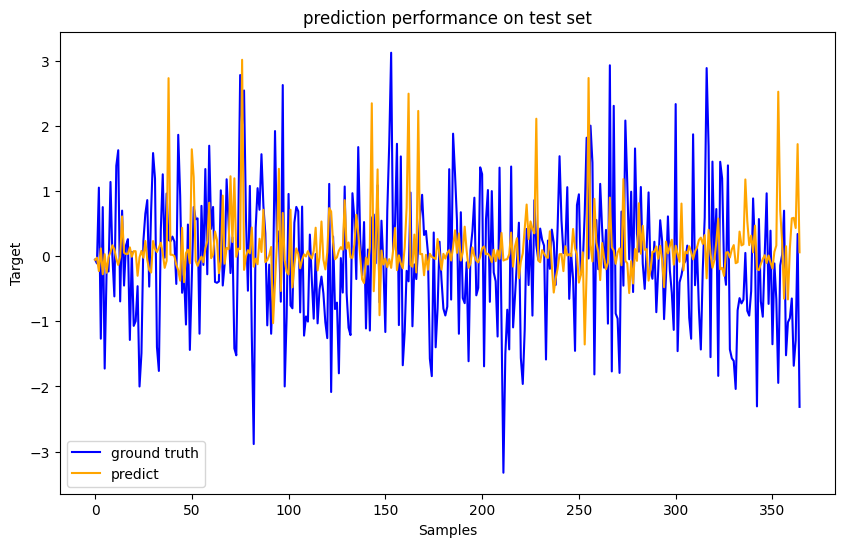

In [23]:
# plot test result
plt.figure(figsize=(10, 6))
plt.plot(y_test_fr, color='blue', label='ground truth')
plt.plot(preds_test, color='orange', label='predict')
plt.xlabel('Samples')
plt.ylabel('Target')
plt.title('prediction performance on test set')
plt.legend()
plt.show()

#### fine tune the model on FR dataset

In [6]:
# use optuna to tune the model
def objective(trial, x_train, y_train):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 200, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    regressor = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    
    score = cross_val_score(regressor, x_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return score

study_fr = optuna.create_study(direction='maximize')
study_fr.optimize(lambda trial: objective(trial, x_train_fr, y_train_fr), n_trials=300)

print('--------------------------------------------')
print('Number of finished trials:', len(study_fr.trials))
print('Best trial:', study_fr.best_trial.params)

[I 2024-03-04 10:51:25,868] A new study created in memory with name: no-name-6413202e-1118-41a6-a2dd-21e8fe65804f
[I 2024-03-04 10:51:32,084] Trial 0 finished with value: -1.1413357770212502 and parameters: {'n_estimators': 271, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: -1.1413357770212502.
[I 2024-03-04 10:51:35,402] Trial 1 finished with value: -1.0934811870129841 and parameters: {'n_estimators': 227, 'max_depth': 186, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 1 with value: -1.0934811870129841.
[I 2024-03-04 10:51:38,227] Trial 2 finished with value: -1.1066198990100617 and parameters: {'n_estimators': 171, 'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 1 with value: -1.0934811870129841.
[I 2024-03-04 10:51:40,961] Trial 3 finished with value: -1.0933434420912451 and parameters: {'n_estimators': 204, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 3 w

[I 2024-03-04 10:53:04,301] Trial 36 finished with value: -1.0942451758976932 and parameters: {'n_estimators': 178, 'max_depth': 151, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 11 with value: -1.0863415657489306.
[I 2024-03-04 10:53:06,779] Trial 37 finished with value: -1.0875495476386645 and parameters: {'n_estimators': 221, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 11 with value: -1.0863415657489306.
[I 2024-03-04 10:53:10,477] Trial 38 finished with value: -1.134438375701808 and parameters: {'n_estimators': 223, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 11 with value: -1.0863415657489306.
[I 2024-03-04 10:53:13,307] Trial 39 finished with value: -1.0942381904433414 and parameters: {'n_estimators': 209, 'max_depth': 42, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 11 with value: -1.0863415657489306.
[I 2024-03-04 10:53:16,968] Trial 40 finished with value: -1.1800778586

[I 2024-03-04 10:54:34,523] Trial 72 finished with value: -1.0867298973051032 and parameters: {'n_estimators': 176, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 10}. Best is trial 60 with value: -1.0850690167332255.
[I 2024-03-04 10:54:36,892] Trial 73 finished with value: -1.086770375459992 and parameters: {'n_estimators': 178, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 10}. Best is trial 60 with value: -1.0850690167332255.
[I 2024-03-04 10:54:39,311] Trial 74 finished with value: -1.091985855252426 and parameters: {'n_estimators': 178, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 10}. Best is trial 60 with value: -1.0850690167332255.
[I 2024-03-04 10:54:41,789] Trial 75 finished with value: -1.088226008117983 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 10}. Best is trial 60 with value: -1.0850690167332255.
[I 2024-03-04 10:54:43,937] Trial 76 finished with value: -1.08671027387359

[I 2024-03-04 10:55:50,979] Trial 108 finished with value: -1.0849594855704257 and parameters: {'n_estimators': 120, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 99 with value: -1.0838100382465297.
[I 2024-03-04 10:55:52,759] Trial 109 finished with value: -1.100743227384706 and parameters: {'n_estimators': 104, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 99 with value: -1.0838100382465297.
[I 2024-03-04 10:55:54,374] Trial 110 finished with value: -1.085605047753636 and parameters: {'n_estimators': 119, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 99 with value: -1.0838100382465297.
[I 2024-03-04 10:55:56,089] Trial 111 finished with value: -1.0857811817636098 and parameters: {'n_estimators': 118, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 99 with value: -1.0838100382465297.
[I 2024-03-04 10:55:57,839] Trial 112 finished with value: -1.086768178005

[I 2024-03-04 10:56:55,351] Trial 144 finished with value: -1.084829074505602 and parameters: {'n_estimators': 124, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 99 with value: -1.0838100382465297.
[I 2024-03-04 10:56:56,913] Trial 145 finished with value: -1.0856987759567815 and parameters: {'n_estimators': 113, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 99 with value: -1.0838100382465297.
[I 2024-03-04 10:56:58,572] Trial 146 finished with value: -1.0850237316998204 and parameters: {'n_estimators': 126, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 99 with value: -1.0838100382465297.
[I 2024-03-04 10:57:00,307] Trial 147 finished with value: -1.13655147236171 and parameters: {'n_estimators': 122, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 99 with value: -1.0838100382465297.
[I 2024-03-04 10:57:02,114] Trial 148 finished with value: -1.09356029332152

[I 2024-03-04 10:58:01,730] Trial 180 finished with value: -1.0913613942604514 and parameters: {'n_estimators': 148, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 151 with value: -1.0838037234340894.
[I 2024-03-04 10:58:03,581] Trial 181 finished with value: -1.0846243069685277 and parameters: {'n_estimators': 145, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 151 with value: -1.0838037234340894.
[I 2024-03-04 10:58:05,398] Trial 182 finished with value: -1.0845723913362426 and parameters: {'n_estimators': 138, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 151 with value: -1.0838037234340894.
[I 2024-03-04 10:58:07,145] Trial 183 finished with value: -1.0846785721855356 and parameters: {'n_estimators': 136, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 151 with value: -1.0838037234340894.
[I 2024-03-04 10:58:09,028] Trial 184 finished with value: -1.0847129

[I 2024-03-04 10:59:09,639] Trial 216 finished with value: -1.0845854463868376 and parameters: {'n_estimators': 146, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 151 with value: -1.0838037234340894.
[I 2024-03-04 10:59:11,626] Trial 217 finished with value: -1.0859339100383194 and parameters: {'n_estimators': 146, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 151 with value: -1.0838037234340894.
[I 2024-03-04 10:59:14,860] Trial 218 finished with value: -1.1054478824375658 and parameters: {'n_estimators': 289, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 151 with value: -1.0838037234340894.
[I 2024-03-04 10:59:16,683] Trial 219 finished with value: -1.0857281098085427 and parameters: {'n_estimators': 151, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 151 with value: -1.0838037234340894.
[I 2024-03-04 10:59:18,855] Trial 220 finished with value: -1.0912706

[I 2024-03-04 11:00:16,365] Trial 252 finished with value: -1.0843756880337314 and parameters: {'n_estimators': 118, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 151 with value: -1.0838037234340894.
[I 2024-03-04 11:00:18,013] Trial 253 finished with value: -1.0857811817636098 and parameters: {'n_estimators': 118, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 151 with value: -1.0838037234340894.
[I 2024-03-04 11:00:19,758] Trial 254 finished with value: -1.0878528490928538 and parameters: {'n_estimators': 127, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 151 with value: -1.0838037234340894.
[I 2024-03-04 11:00:21,322] Trial 255 finished with value: -1.086317696425865 and parameters: {'n_estimators': 110, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 151 with value: -1.0838037234340894.
[I 2024-03-04 11:00:23,017] Trial 256 finished with value: -1.08522657

[I 2024-03-04 11:01:19,179] Trial 288 finished with value: -1.0861155716604483 and parameters: {'n_estimators': 111, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 151 with value: -1.0838037234340894.
[I 2024-03-04 11:01:21,102] Trial 289 finished with value: -1.0898469723796889 and parameters: {'n_estimators': 121, 'max_depth': 97, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 151 with value: -1.0838037234340894.
[I 2024-03-04 11:01:22,689] Trial 290 finished with value: -1.0848290745056022 and parameters: {'n_estimators': 124, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 151 with value: -1.0838037234340894.
[I 2024-03-04 11:01:24,316] Trial 291 finished with value: -1.0860028301078928 and parameters: {'n_estimators': 117, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 151 with value: -1.0838037234340894.
[I 2024-03-04 11:01:25,865] Trial 292 finished with value: -1.08795

--------------------------------------------
Number of finished trials: 300
Best trial: {'n_estimators': 122, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 10}


In [7]:
# calculate loss with best model found
best_params_fr = study_fr.best_trial.params
best_regressor_fr = RandomForestRegressor(**best_params_fr, random_state=42, n_jobs=-1)
best_regressor_fr.fit(x_train_fr, y_train_fr)

preds_train_fr = best_regressor_fr.predict(x_train_fr)
preds_test_fr = best_regressor_fr.predict(x_test_fr)

error_train_fr = mean_squared_error(preds_train_fr, y_train_fr)
error_test_fr = mean_squared_error(preds_test_fr, y_test_fr)

spearmanr_train_fr = spearmanr(preds_train_fr, y_train_fr).correlation
spearmanr_test_fr = spearmanr(preds_test_fr, y_test_fr).correlation

print('MSE of train set (FR): ', error_train_fr)
print('Spearman correlation for the train set: {:.1f}%'.format(100 * spearmanr_train_fr ))
print('MSE of test set (FR): ', error_test_fr)
print('Spearman correlation for the test set: {:.1f}%'.format(100 * spearmanr_test_fr ))

MSE of train set (FR):  0.8678721044383454
Spearman correlation for the train set: 42.7%
MSE of test set (FR):  1.1633198736289594
Spearman correlation for the test set: -7.2%


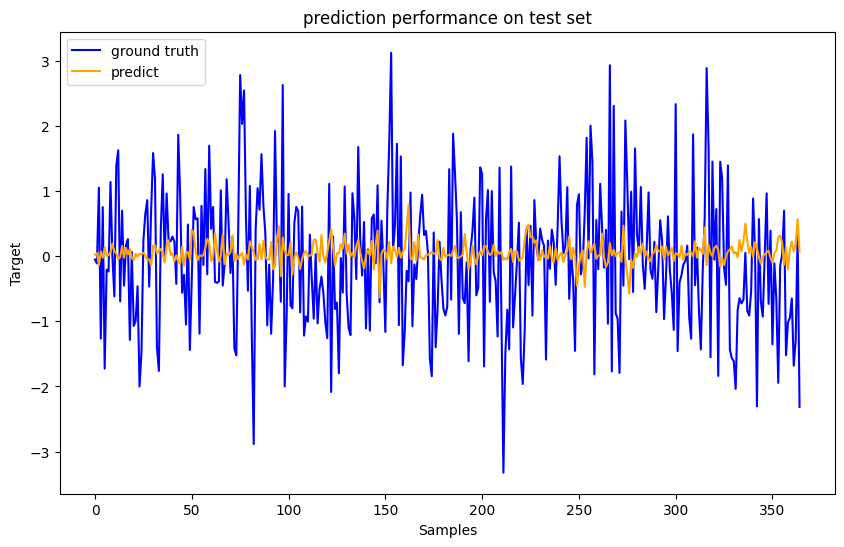

In [8]:
# plot test result
plt.figure(figsize=(10, 6))
plt.plot(y_test_fr, color='blue', label='ground truth')
plt.plot(preds_test_fr, color='orange', label='predict')
plt.xlabel('Samples')
plt.ylabel('Target')
plt.title('prediction performance on test set')
plt.legend()
plt.show()

#### tune the model on DE dataset

In [9]:
study_de = optuna.create_study(direction='maximize')
study_de.optimize(lambda trial: objective(trial, x_train_de, y_train_de), n_trials=300)

print('--------------------------------------------')
print('Number of finished trials:', len(study_de.trials))
print('Best trial:', study_de.best_trial.params)

[I 2024-03-04 11:01:38,367] A new study created in memory with name: no-name-d6033195-095a-43f2-b330-bf6d9c6b7623
[I 2024-03-04 11:01:41,912] Trial 0 finished with value: -1.0658344551676384 and parameters: {'n_estimators': 283, 'max_depth': 58, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 0 with value: -1.0658344551676384.
[I 2024-03-04 11:01:44,245] Trial 1 finished with value: -1.1059528094217868 and parameters: {'n_estimators': 125, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: -1.0658344551676384.
[I 2024-03-04 11:01:46,522] Trial 2 finished with value: -1.0491467338287648 and parameters: {'n_estimators': 188, 'max_depth': 85, 'min_samples_split': 14, 'min_samples_leaf': 9}. Best is trial 2 with value: -1.0491467338287648.
[I 2024-03-04 11:01:49,253] Trial 3 finished with value: -1.0506635733921812 and parameters: {'n_estimators': 228, 'max_depth': 59, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 2 

[I 2024-03-04 11:02:57,545] Trial 36 finished with value: -1.0480950052086722 and parameters: {'n_estimators': 150, 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 10}. Best is trial 34 with value: -1.0469451141416857.
[I 2024-03-04 11:02:59,488] Trial 37 finished with value: -1.0473300256406752 and parameters: {'n_estimators': 140, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 34 with value: -1.0469451141416857.
[I 2024-03-04 11:03:01,373] Trial 38 finished with value: -1.0465466077109054 and parameters: {'n_estimators': 135, 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 38 with value: -1.0465466077109054.
[I 2024-03-04 11:03:02,920] Trial 39 finished with value: -1.0796435038552759 and parameters: {'n_estimators': 89, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 3}. Best is trial 38 with value: -1.0465466077109054.
[I 2024-03-04 11:03:04,665] Trial 40 finished with value: -1.049960892

[I 2024-03-04 11:04:07,059] Trial 72 finished with value: -1.0483741960620452 and parameters: {'n_estimators': 151, 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 38 with value: -1.0465466077109054.
[I 2024-03-04 11:04:08,982] Trial 73 finished with value: -1.0472666649518545 and parameters: {'n_estimators': 136, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 10}. Best is trial 38 with value: -1.0465466077109054.
[I 2024-03-04 11:04:10,795] Trial 74 finished with value: -1.0482273466854548 and parameters: {'n_estimators': 127, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 38 with value: -1.0465466077109054.
[I 2024-03-04 11:04:12,477] Trial 75 finished with value: -1.0489191288786146 and parameters: {'n_estimators': 107, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 9}. Best is trial 38 with value: -1.0465466077109054.
[I 2024-03-04 11:04:14,354] Trial 76 finished with value: -1.048241604

[I 2024-03-04 11:04:47,751] Trial 108 finished with value: -1.051118745163449 and parameters: {'n_estimators': 215, 'max_depth': 23, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:04:48,672] Trial 109 finished with value: -1.0473289934948626 and parameters: {'n_estimators': 136, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 9}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:04:49,484] Trial 110 finished with value: -1.0470471687798182 and parameters: {'n_estimators': 113, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:04:50,372] Trial 111 finished with value: -1.047385140446082 and parameters: {'n_estimators': 128, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:04:51,153] Trial 112 finished with value: -1.046820264

[I 2024-03-04 11:05:19,243] Trial 144 finished with value: -1.0478439510387887 and parameters: {'n_estimators': 139, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:05:20,028] Trial 145 finished with value: -1.0484134060578612 and parameters: {'n_estimators': 108, 'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 10}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:05:20,918] Trial 146 finished with value: -1.0471480512076128 and parameters: {'n_estimators': 124, 'max_depth': 13, 'min_samples_split': 13, 'min_samples_leaf': 9}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:05:21,790] Trial 147 finished with value: -1.0472272953048152 and parameters: {'n_estimators': 134, 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 10}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:05:22,647] Trial 148 finished with value: -1.0509222

[I 2024-03-04 11:05:51,877] Trial 180 finished with value: -1.0551274375713429 and parameters: {'n_estimators': 136, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:05:52,753] Trial 181 finished with value: -1.0469743910337148 and parameters: {'n_estimators': 140, 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:05:53,705] Trial 182 finished with value: -1.0472509456991628 and parameters: {'n_estimators': 134, 'max_depth': 28, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:05:54,644] Trial 183 finished with value: -1.0476202560847543 and parameters: {'n_estimators': 143, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:05:55,486] Trial 184 finished with value: -1.04754788

[I 2024-03-04 11:06:23,672] Trial 216 finished with value: -1.0465570737640264 and parameters: {'n_estimators': 137, 'max_depth': 12, 'min_samples_split': 11, 'min_samples_leaf': 10}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:06:24,411] Trial 217 finished with value: -1.0476083879882634 and parameters: {'n_estimators': 124, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:06:25,258] Trial 218 finished with value: -1.0476747046132346 and parameters: {'n_estimators': 131, 'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 10}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:06:26,058] Trial 219 finished with value: -1.0474834599116913 and parameters: {'n_estimators': 142, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 10}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:06:26,917] Trial 220 finished with value: -1.04742060

[I 2024-03-04 11:06:53,358] Trial 252 finished with value: -1.0478226756335192 and parameters: {'n_estimators': 149, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:06:54,226] Trial 253 finished with value: -1.0817479237481753 and parameters: {'n_estimators': 135, 'max_depth': 107, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:06:55,552] Trial 254 finished with value: -1.0508364190411645 and parameters: {'n_estimators': 235, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:06:56,257] Trial 255 finished with value: -1.0474725165087337 and parameters: {'n_estimators': 119, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 81 with value: -1.046465638733415.
[I 2024-03-04 11:06:57,026] Trial 256 finished with value: -1.04693774

[I 2024-03-04 11:07:24,247] Trial 288 finished with value: -1.046414675766993 and parameters: {'n_estimators': 129, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 9}. Best is trial 287 with value: -1.046406076070874.
[I 2024-03-04 11:07:25,063] Trial 289 finished with value: -1.046776019153173 and parameters: {'n_estimators': 128, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 9}. Best is trial 287 with value: -1.046406076070874.
[I 2024-03-04 11:07:25,997] Trial 290 finished with value: -1.046406076070874 and parameters: {'n_estimators': 129, 'max_depth': 43, 'min_samples_split': 15, 'min_samples_leaf': 9}. Best is trial 287 with value: -1.046406076070874.
[I 2024-03-04 11:07:26,842] Trial 291 finished with value: -1.047715428770045 and parameters: {'n_estimators': 123, 'max_depth': 34, 'min_samples_split': 15, 'min_samples_leaf': 9}. Best is trial 287 with value: -1.046406076070874.
[I 2024-03-04 11:07:27,672] Trial 292 finished with value: -1.0464060760

--------------------------------------------
Number of finished trials: 300
Best trial: {'n_estimators': 129, 'max_depth': 33, 'min_samples_split': 15, 'min_samples_leaf': 9}


In [10]:
# calculate loss with best model found
best_params_de = study_de.best_trial.params
best_regressor_de = RandomForestRegressor(**best_params_de, random_state=42, n_jobs=-1)
best_regressor_de.fit(x_train_de, y_train_de)

preds_train_de = best_regressor_de.predict(x_train_de)
preds_test_de = best_regressor_de.predict(x_test_de)

error_train_de = mean_squared_error(preds_train_de, y_train_de)
error_test_de = mean_squared_error(preds_test_de, y_test_de)

spearmanr_train_de = spearmanr(preds_train_de, y_train_de).correlation
spearmanr_test_de = spearmanr(preds_test_de, y_test_de).correlation

print('MSE of train set (DE): ', error_train_de)
print('Spearman correlation for the train set: {:.1f}%'.format(100 * spearmanr_train_de ))
print('MSE of test set (DE): ', error_test_de)
print('Spearman correlation for the test set: {:.1f}%'.format(100 * spearmanr_test_de ))

MSE of train set (DE):  0.6326787106320133
Spearman correlation for the train set: 80.7%
MSE of test set (DE):  1.1782788371727797
Spearman correlation for the test set: -3.0%


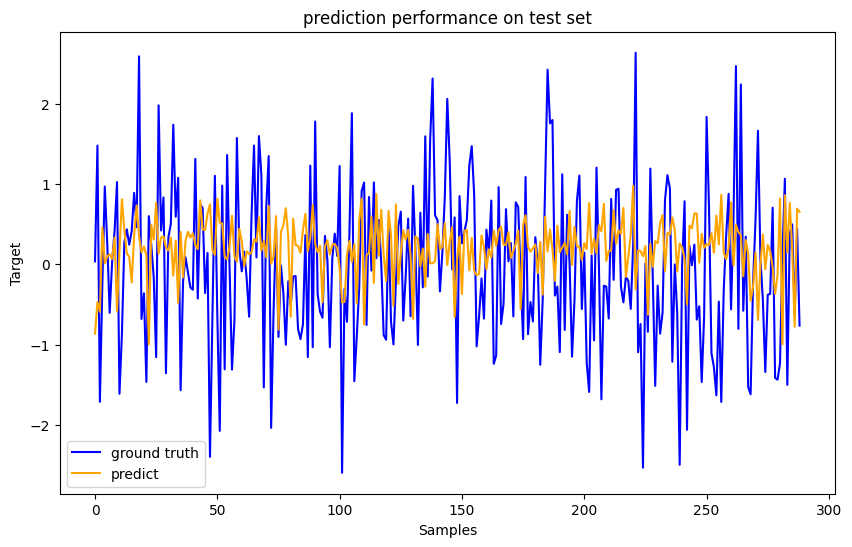

In [11]:
# plot test result
plt.figure(figsize=(10, 6))
plt.plot(y_test_de, color='blue', label='ground truth')
plt.plot(preds_test_de, color='orange', label='predict')
plt.xlabel('Samples')
plt.ylabel('Target')
plt.title('prediction performance on test set')
plt.legend()
plt.show()

#### combine the result of both model

In [12]:
total_y_test = np.concatenate((y_test_fr, y_test_de))
total_y_train = np.concatenate((y_train_fr, y_train_de))
total_preds_test = np.concatenate((preds_test_fr,preds_test_de))
total_preds_train = np.concatenate((preds_train_fr,preds_train_de))

error_train_total = mean_squared_error(total_preds_train, total_y_train)
error_test_total = mean_squared_error(total_preds_test, total_y_test)

spearmanr_train_total = spearmanr(total_preds_train, total_y_train).correlation
spearmanr_test_total = spearmanr(total_preds_test, total_y_test).correlation

print('MSE of train set (total): ', error_train_total)
print('Spearman correlation for the train set: {:.1f}%'.format(100 * spearmanr_train_total ))
print('MSE of test set (total): ', error_test_total)
print('Spearman correlation for the test set: {:.1f}%'.format(100 * spearmanr_test_total ))

MSE of train set (total):  0.7666476384293281
Spearman correlation for the train set: 60.6%
MSE of test set (total):  1.169930180149088
Spearman correlation for the test set: -2.9%


In [14]:
print(spearmanr_train_total)
print(spearmanr_test_total)

0.6059808316968125
-0.028938951996565494


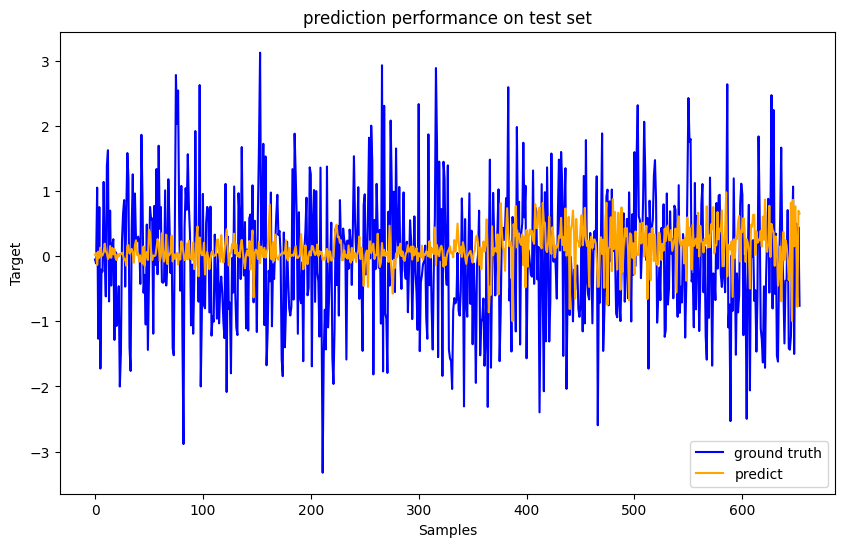

In [13]:
# plot test result
plt.figure(figsize=(10, 6))
plt.plot(total_y_test, color='blue', label='ground truth')
plt.plot(total_preds_test, color='orange', label='predict')
plt.xlabel('Samples')
plt.ylabel('Target')
plt.title('prediction performance on test set')
plt.legend()
plt.show()